In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import glob
from skimage.feature import hog

In [2]:
def visualize_images(input_images, num_cols, figure_name, cmap = None):
    "Shows input images by stacking them in num_cols columns"
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.manager.set_window_title(figure_name)
    
    print(figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

In [3]:
vehicles_dir =     './vehicles/'
non_vehicles_dir = './non-vehicles/'

# images are divided up into vehicles and non-vehicles
cars = []
notcars = []

# Read vehicle images
images = glob.iglob(vehicles_dir + '/**/*.png', recursive=True)

for image in images:
        cars.append(image)
        
# Read non-vehicle images
images = glob.iglob(non_vehicles_dir + '/**/*.png', recursive=True)

for image in images:
        notcars.append(image)

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    """
    Convert the image from one color space to the other
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'Gray':
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

Text(0.5, 1.0, 'YUV')

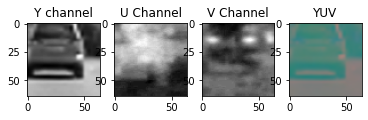

In [5]:
car = plt.imread(cars[1])
notcar = plt.imread(notcars[1])

fig = plt.figure()
plt.subplot(141)
yuv_image = convert_color(car, 'RGB2YUV')
plt.imshow(yuv_image[:,:,0], cmap ="gray")
plt.title('Y channel')
plt.subplot(142)
plt.imshow(yuv_image[:,:,1], cmap ="gray")
plt.title('U Channel')
plt.subplot(143)
plt.imshow(yuv_image[:,:,2], cmap ="gray")
plt.title('V Channel')
plt.subplot(144)
plt.imshow(yuv_image)
plt.title('YUV')

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    Return the hog features of the given input image
    Call with two outputs if vis==True"""
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

Text(0.5, 1.0, 'not car HOG Visualization')

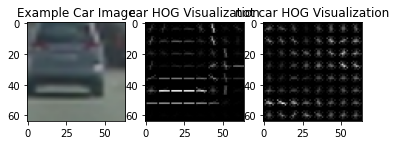

In [7]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

car_features, hog_image = get_hog_features(cv2.cvtColor(car, cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

notcar_features, notcar_hog_image = get_hog_features(cv2.cvtColor(notcar, cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(131)
plt.imshow(car)
plt.title('Example Car Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('car HOG Visualization')
plt.subplot(133)
plt.imshow(notcar_hog_image, cmap='gray')
plt.title('not car HOG Visualization')

In [8]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2):

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        image = (image * 255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        

        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)   

        # Append the new feature vector to the features list
        file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [9]:
# Train

colorspace = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size=(32, 32)
hist_bins=32

t=time.time()

car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.15, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC X_scaler
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

KeyboardInterrupt: 

In [ ]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
#Save the model

import pickle

# Save the model
data_file = 'svc_pickle.sav'
pickle.dump(
            {
                'svc': svc,
                'scaler': X_scaler,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins

            },
            open(data_file, 'wb'))
print(f'Model has been saved to {data_file}')

In [ ]:
# Load the model
import pickle

def load(data_file):
    dist_pickle = pickle.load(open(f"{data_file}", "rb" ))
    return dist_pickle

data_file = './svc_pickle.sav'
dist_pickle = load(data_file)
print(dist_pickle)
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

In [10]:
test_images_dir = './test_images/'

test_images = []

images = glob.glob(test_images_dir + '*.jpg')

for image in images:
        test_images.append(mpimg.imread(image))